<a href="https://colab.research.google.com/github/dkalenov/ML-Trading/blob/2_supervised-learning/Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Case Study

Crypto exchanges (e.g. Bybit) allows customers to trade based on the size of Move for Bitcoin. If we can determine a model, which can forecast better than 50/50 accuracy, whether or not Bitcoins move will likely be above it's average, then we have an edge.

The catch is, how to predict whether future volatility will be above or below the rolling average (assuming that the rolling average is where the market adjusts to). Regardless, this will be a significant challenge and we will need state-of-the-art methods, whilst making sure we do not overfit.

### Imports

In [1]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=612d79dc325489acb3d884084319f13aac8e69ba32cc534d990c59a9253e46ef
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [2]:
import numpy as np
import pandas as pd
import sklearn.mixture as mix
from ta.momentum import RSIIndicator
import matplotlib.pyplot as plt

In [3]:
 !pip install pandas-datareader

### Data Extraction and Returns Overview

In [4]:
import numpy as np
import yfinance as yf

# Create the class
class StrategyManager():

    # Initialize the class
    def __init__(self, symbol, start_date, end_date):
        self.df = self._extract_data(symbol, start_date, end_date)
        self.sharpe = 0

    # Extract data
    def _extract_data(self, symbol, start_date, end_date):
        from pandas_datareader.data import DataReader
        data = yf.download(symbol, start_date, end_date)
        #data = DataReader(name=symbol, data_source='yahoo', start=start_date, end=end_date)
        data = data[["Open", "High", "Low", "Close", "Volume"]]
        data = self._structure_df(data)
        return data

    # Calculates general period returns and volatility
    def _structure_df(self, df):
        df["Returns"] = df["Close"].pct_change()
        df["Range"] = df["High"] / df["Low"] - 1
        df["Bench_C_Rets"], sharpe = self._calculate_returns(df, True)
        self.sharpe = sharpe
        df.dropna(inplace=True)
        return df

    # Adjusts the signal to represent our strategy
    def _set_multiplier(self, direction):
        if direction == "long":
            pos_multiplier = 1
            neg_multiplier = 0
        elif direction == "long_short":
            pos_multiplier = 1
            neg_multiplier = -1
        else:
            pos_multiplier = 0
            neg_multiplier = -1
        return pos_multiplier, neg_multiplier

    # Calculates returns for equity curve
    def _calculate_returns(self, df, is_benchmark):

        # Calculate multiplier
        if not is_benchmark:
            multiplier_1 = df["Signal"]
            multiplier_2 = 1 if "PSignal" not in df.columns else df["PSignal"]
            log_rets = np.log(df["Close"] / df["Close"].shift(1)) * multiplier_1 * multiplier_2
        else:
            multiplier_1 = 1
            multiplier_2 = 1

            # Assume open price on following day to avoid lookahead bias for close calculation
            log_rets = np.log(df["Open"].shift(-1) / df["Close"].shift(1)) * multiplier_1 * multiplier_2

        # Calculate Sharpe Ratio
        sharpe_ratio = self.sharpe_ratio(log_rets)

        # Calculate Cumulative Returns
        c_log_rets = log_rets.cumsum()
        c_log_rets_exp = np.exp(c_log_rets) - 1

        # Return result and Sharpe ratio
        return c_log_rets_exp, sharpe_ratio

    def sharpe_ratio(self, return_series):
        N = 255 # Trading days in the year (change to 365 for crypto)
        rf = 0.005 # Half a percent risk free rare
        mean = return_series.mean() * N -rf
        sigma = return_series.std() * np.sqrt(N)
        sharpe = round(mean / sigma, 3)
        return sharpe

    # Replace Dataframe
    def change_df(self, new_df, drop_cols=[]):
        new_df = new_df.drop(columns=drop_cols)
        self.df = new_df

    # Moving average crossover strategy
    def backtest_ma_crossover(self, period_1, period_2, direction, drop_cols=[]):

        # Set df
        df = self.df

        # Get multipliers
        pos_multiplier, neg_multiplier = self._set_multiplier(direction)

        # Calculate Moving Averages
        if f"MA_{period_1}" or f"MA_{period_2}" not in df.columns:
            df[f"MA_{period_1}"] = df["Close"].rolling(window=period_1).mean()
            df[f"MA_{period_2}"] = df["Close"].rolling(window=period_2).mean()
            df.dropna(inplace=True)

        # Calculate Benchmark Returns
        df["Bench_C_Rets"], sharpe_ratio_bench = self._calculate_returns(df, True)

        # Calculate Signal
        df.loc[df[f"MA_{period_1}"] > df[f"MA_{period_2}"], "Signal"] = pos_multiplier
        df.loc[df[f"MA_{period_1}"] <= df[f"MA_{period_2}"], "Signal"] = neg_multiplier

        # Calculate Strategy Returns
        df["Strat_C_Rets"], sharpe_ratio_strat = self._calculate_returns(df, False)

        # Get values for output
        bench_rets = df["Bench_C_Rets"].values.astype(float)
        strat_rets = df["Strat_C_Rets"].values.astype(float)
        print("Sense check: ", round(df["Close"].values[-1] / df["Close"].values[0] - 1, 3), round(bench_rets[-1], 3))

        # Remove irrelevant features
        if len(drop_cols) > 0:
            df = df.drop(columns=drop_cols)

        # Ensure Latest DF matches
        df = df.dropna()
        self.df = df

        # Return df
        return df, sharpe_ratio_bench, sharpe_ratio_strat

In [5]:
# Extract Data
start_date = "2017-01-01"
end_date = "2024-03-31"
symbol = "BTC-USD"
strat_mgr = StrategyManager(symbol, start_date, end_date)
df = strat_mgr.df.copy()
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets
Date,,,,,,,,
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,222184992,0.023464,0.034803,0.023314
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000,0.021620,0.022005,0.045999
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984,0.106233,0.110130,0.159122
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,510199008,-0.122410,0.308302,0.018098
2017-01-06,1014.239990,1046.810059,883.943970,902.200989,351876000,-0.109711,0.184249,-0.092307


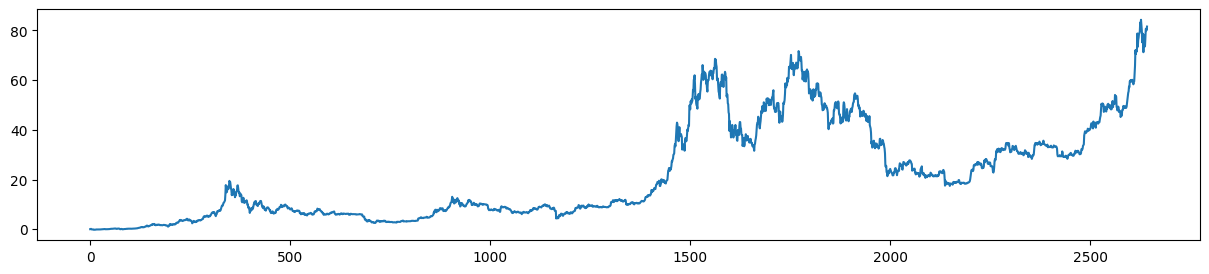

In [10]:
# Benchmark Returns Profile
fig = plt.figure(figsize = (15, 3))
plt.plot(df["Bench_C_Rets"].values)
plt.show()

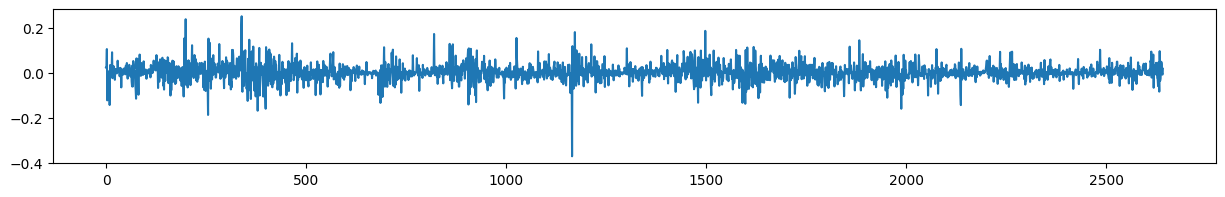

In [12]:
# Benchmark Returns Profile
fig = plt.figure(figsize = (15, 2))
plt.plot(df["Returns"].values)
plt.show()

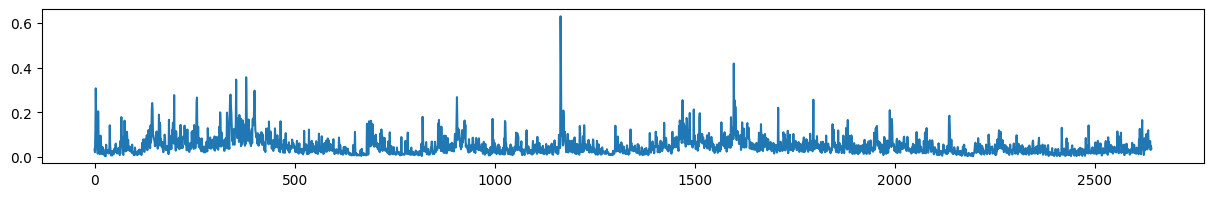

In [13]:
# Benchmark Range Profile
fig = plt.figure(figsize = (15, 2))
plt.plot(df["Range"].values)
plt.show()